In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from utility.data_generator import make_multitarget_regression
from utility.rectangle import Rectangle
from utility.graphing_tools import short_cut_illustration, small_sample_illustration, single_dim_text_file

# styles fix
plt.rcParams.update({
    "font.size": 9, 
    "axes.labelsize": 9,
    "axes.titlesize": 10,
    "legend.fontsize": 8.5,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
})

# Data generation

In [2]:
# Training and test data
X, y, coef_true = make_multitarget_regression(n_samples=5000, n_features=10, n_informative= 10, n_targets=2, noise_list=[2, 1], random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
prediction_test = model.predict(X_test)
scores_test = np.abs(prediction_test - y_test)

# Calibration n=10, 20, 50
X_cal10, y_cal10 = make_multitarget_regression(n_samples=10, n_features=10, n_informative= 10, n_targets=2, noise_list=[2, 1], random_state=77, coef=coef_true)
X_cal20, y_cal20 = make_multitarget_regression(n_samples=20, n_features=10, n_informative= 10, n_targets=2, noise_list=[4, 1], random_state=82, coef=coef_true)
X_cal50, y_cal50 = make_multitarget_regression(n_samples=50, n_features=10, n_informative= 10, n_targets=2, noise_list=[2, 1], random_state=77, coef=coef_true)

prediction_cal10 = model.predict(X_cal10)
scores_cal10 = np.abs(prediction_cal10 - y_cal10)

prediction_cal20 = model.predict(X_cal20)
scores_cal20 = np.abs(prediction_cal20 - y_cal20)

prediction_cal50 = model.predict(X_cal50)
scores_cal50 = np.abs(prediction_cal50 - y_cal50)

# Illustrations generation

## Short-cut

### n=10

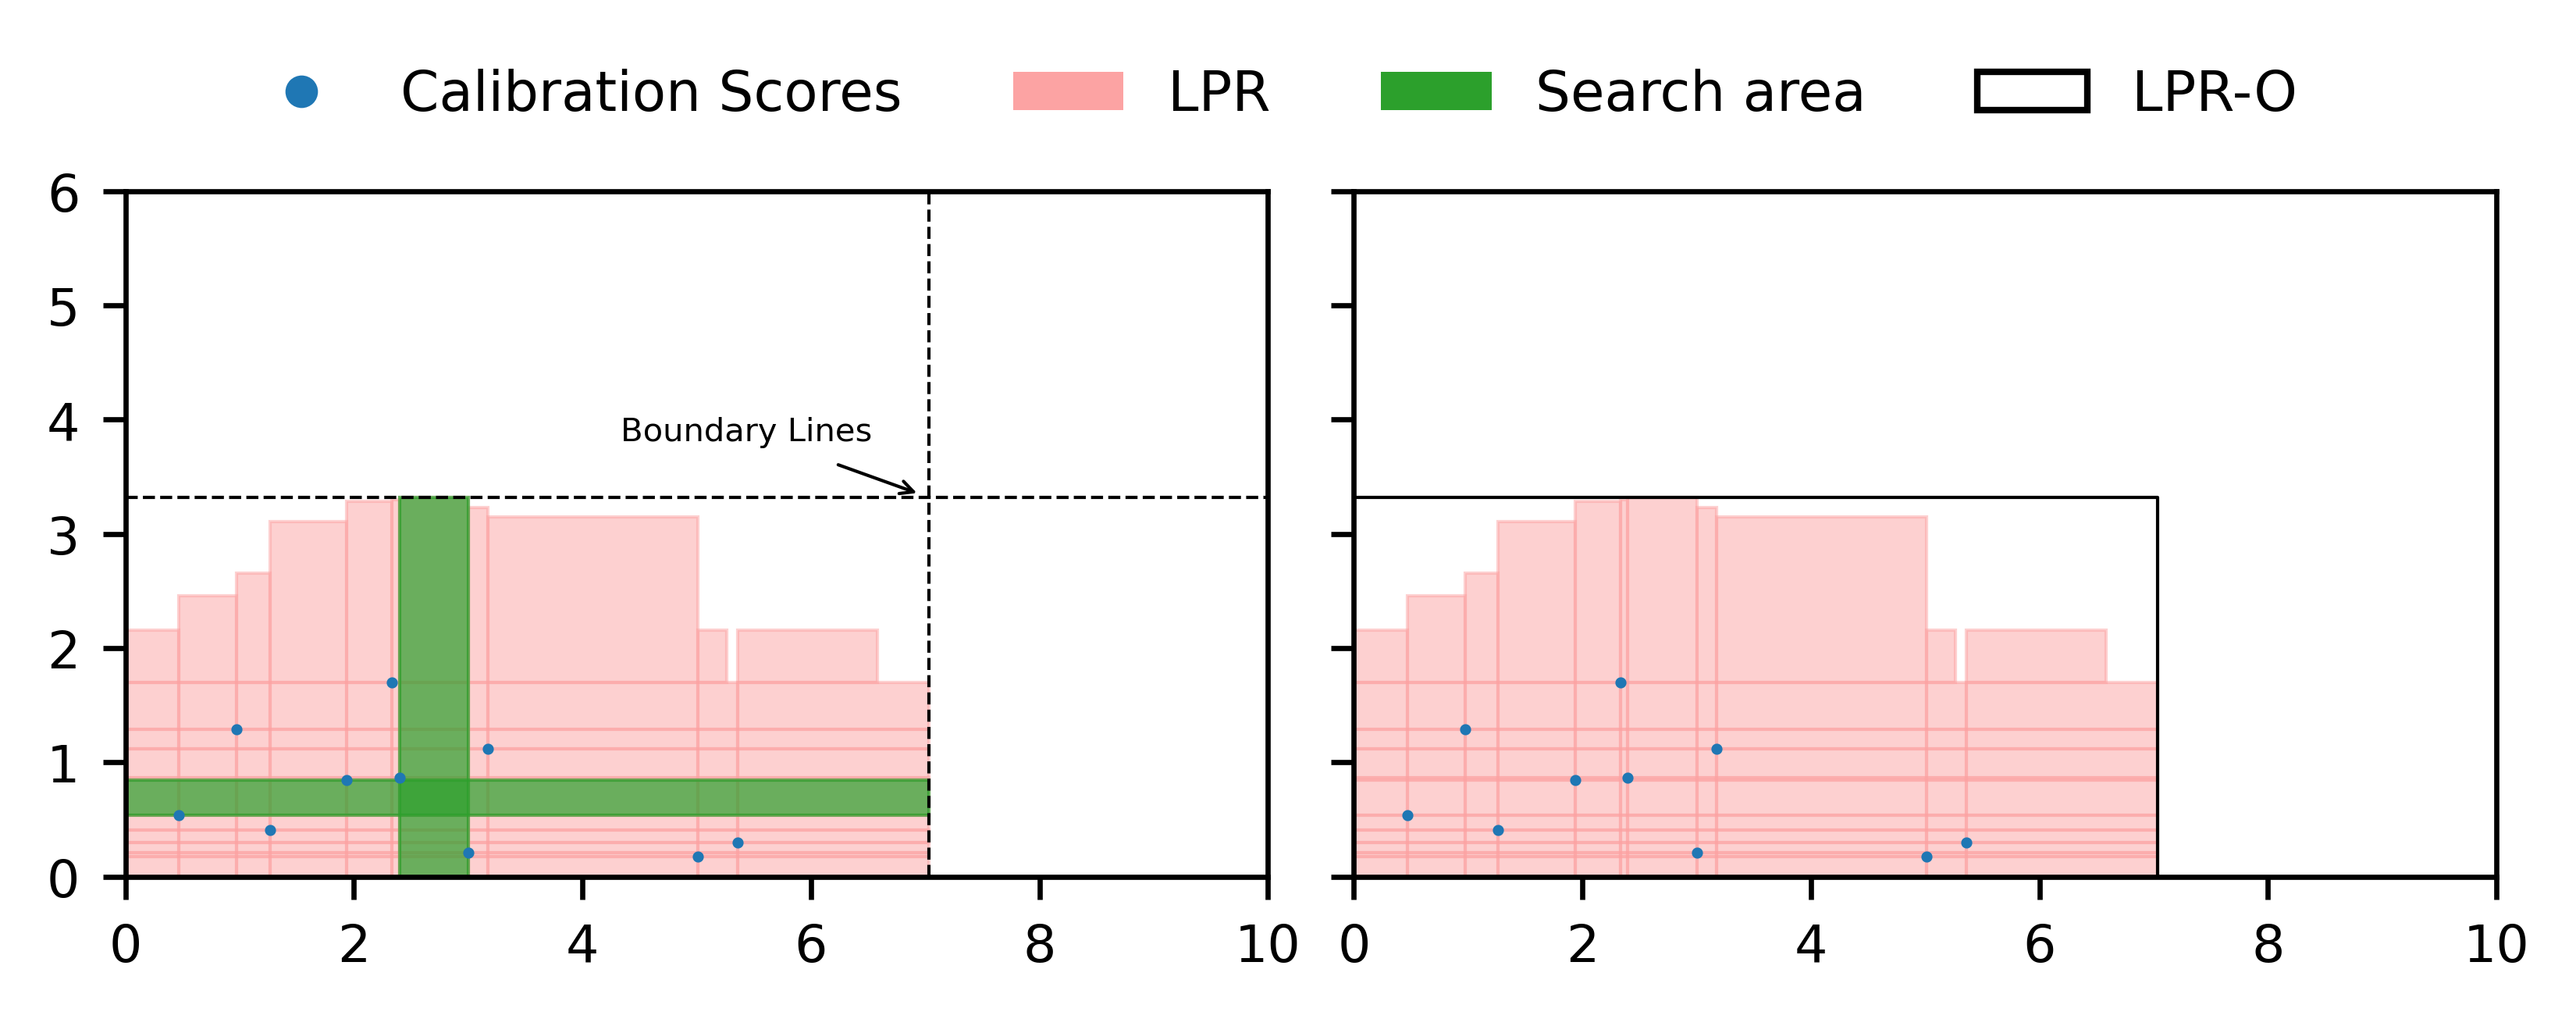

In [3]:
fig, axes = short_cut_illustration(scores=scores_cal10, alpha=0.2)
for ax in axes:
    ax.set(xlim=(0, 10), ylim=(0, 6))
fig.savefig("illustrations_in_paper/short_cut_10.pdf", bbox_inches="tight")

### n=50

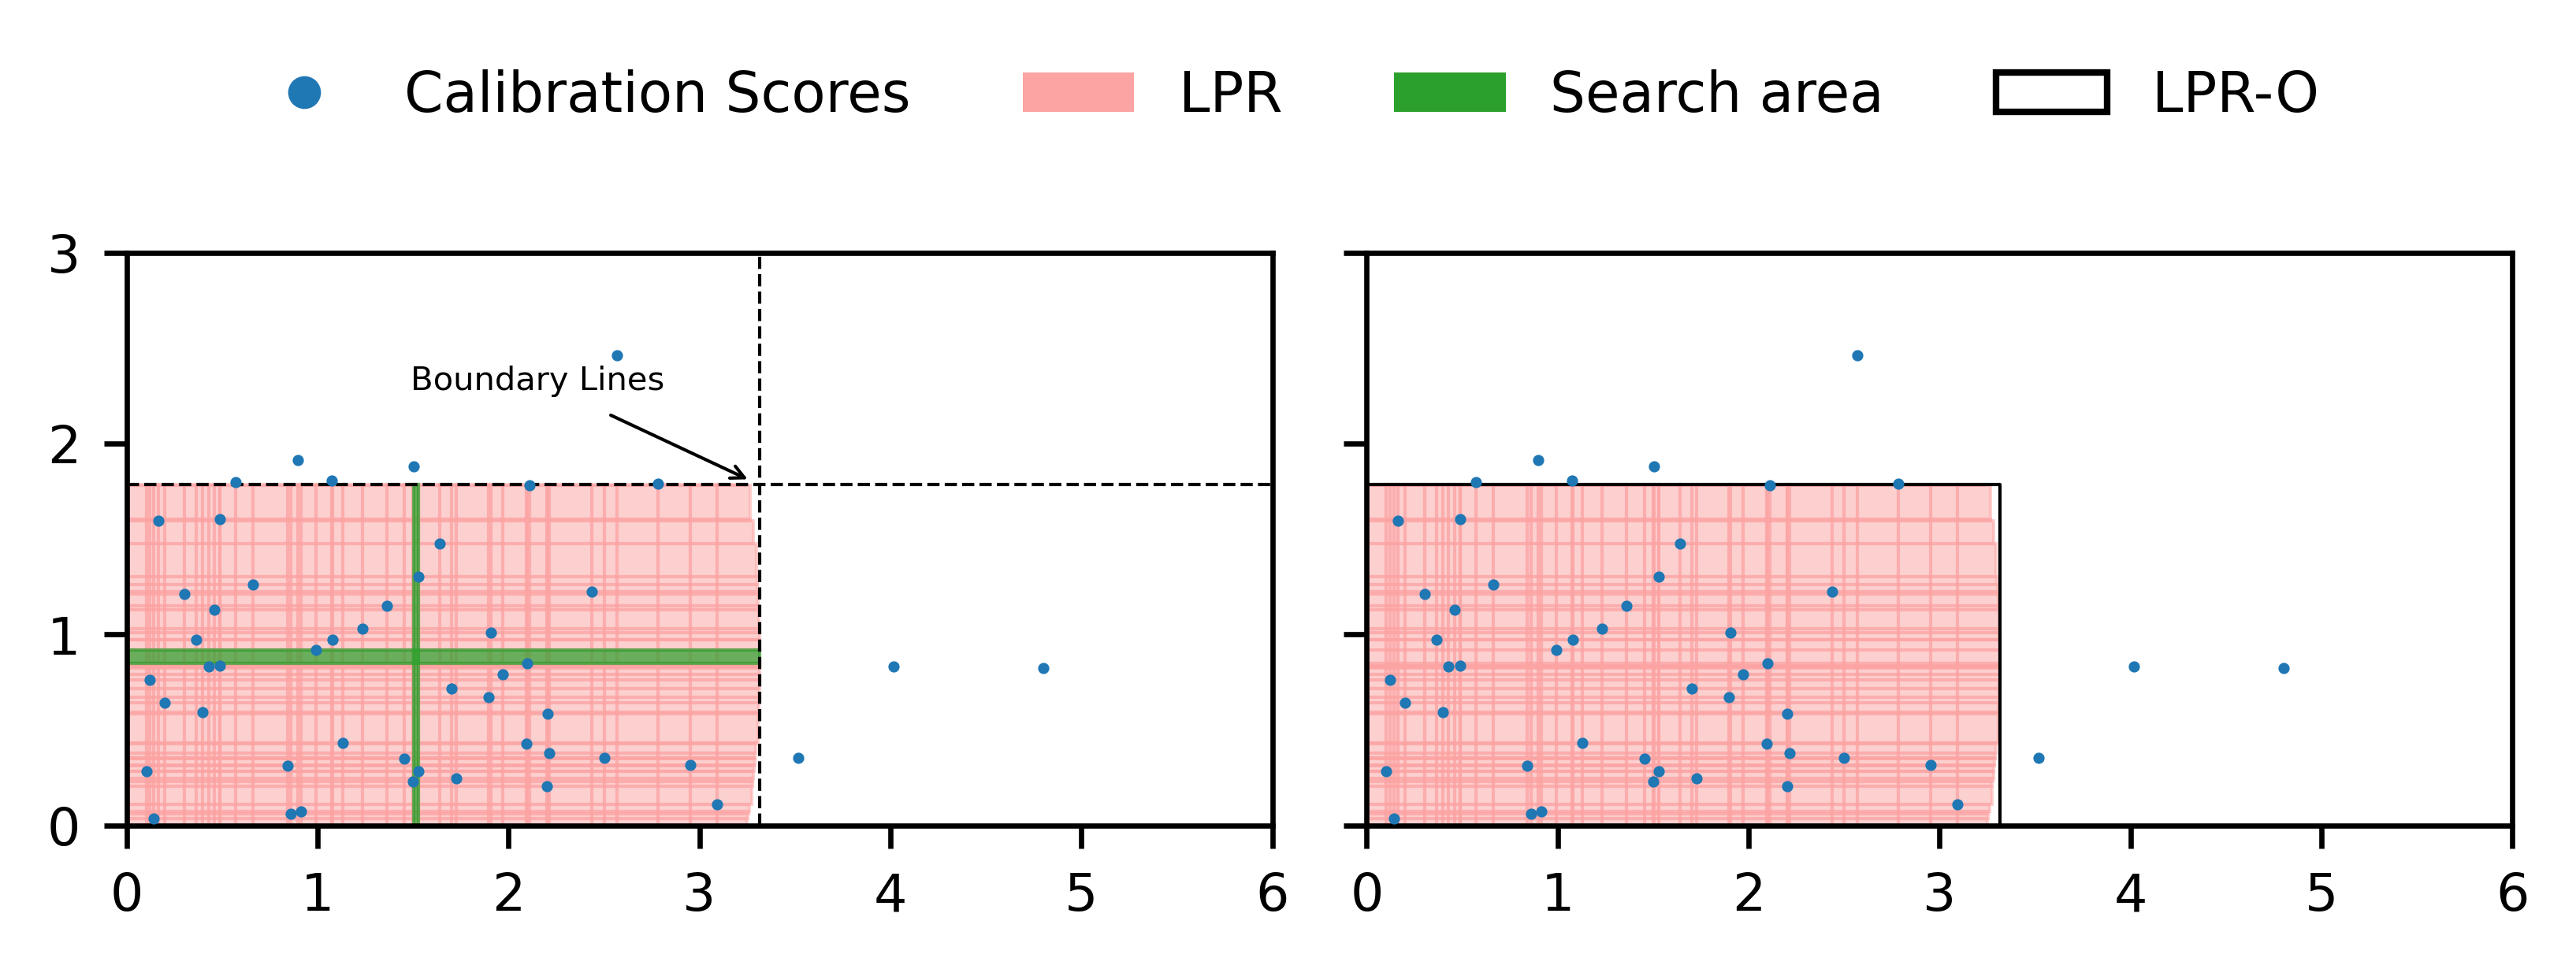

In [4]:
fig, axes = short_cut_illustration(scores_cal50, alpha=0.2)
for ax in axes:
    ax.set(xlim=(0, 6), ylim=(0, 3))
fig.savefig("illustrations_in_paper/short_cut_50.pdf", bbox_inches="tight")

## Overcoverage in small samples

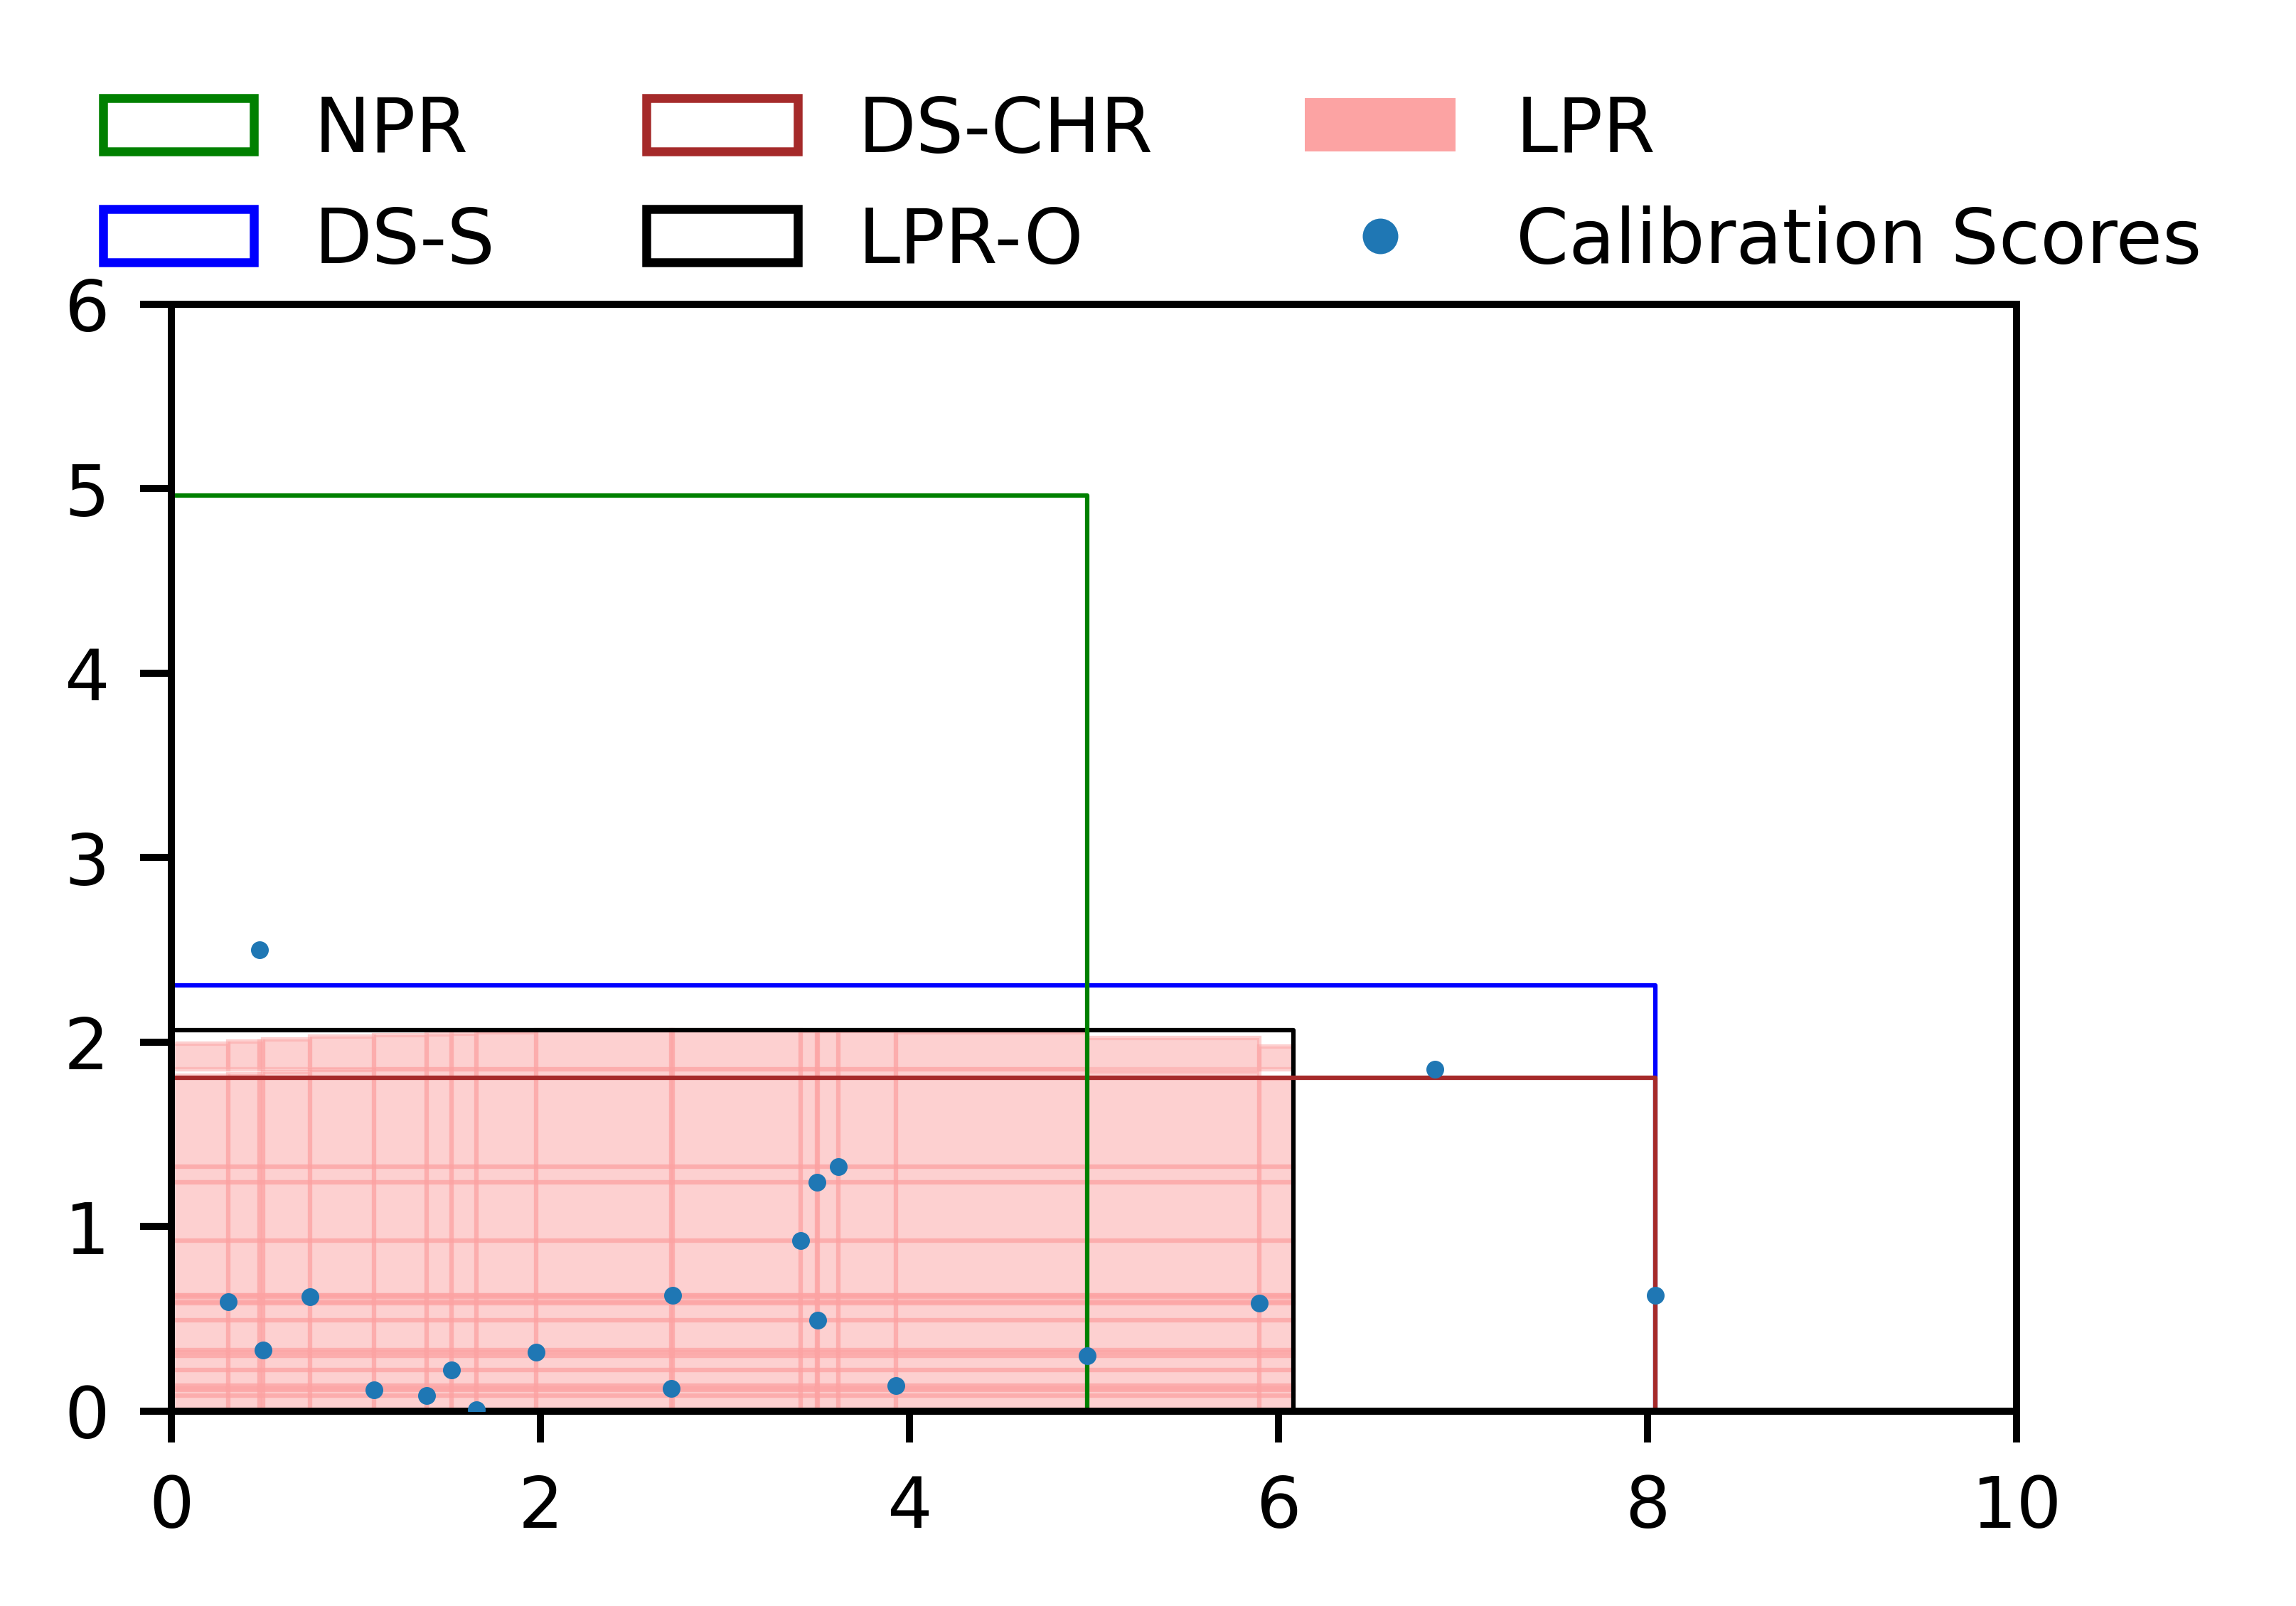

In [4]:
fig, ax = small_sample_illustration(scores_cal20, 0.2, bbox_to_anchor=(0.55, 1.15))
ax.set(xlim=(0, 10), ylim=(0,6))
fig.savefig("illustrations_in_paper/NPR_DS_LPR_prediction_region.pdf", dpi=900, bbox_inches="tight")

In [4]:
def single_dim_latex_table(methods, dim, sample_list, trials, alpha, noise_list, log_scale = True, output_path="results_table.tex"):
    from utility.exps import run_synthetic_experiment
    import pandas as pd

    all_outputs = []

    for method in methods:
        df = run_synthetic_experiment(
            dim_list=[dim],
            sample_list=sample_list,
            alpha_list=[alpha],
            trials=trials,
            method=method,
            noises_list=noise_list,
            log_scale=log_scale
        )
        df["method"] = method
        all_outputs.append(df)

    df_all = pd.concat(all_outputs, ignore_index=True)

    # Sort and group for LaTeX formatting
    df_all = df_all.sort_values(by=["n_scores", "method"])

    # Prepare LaTeX table header
    latex_lines = [
        r"\begin{tabular}{c l r r r}",
        r"\toprule",
        r"\textbf{n Trials} & \textbf{Method Name} & \textbf{Volume (±SD)} & \textbf{Test Coverage (±SD)} & \textbf{Runtime (s)} \\",
        r"\midrule"
    ]

    for n_scores in sorted(df_all["n_scores"].unique()):
        subset = df_all[df_all["n_scores"] == n_scores]
        for i, row in subset.iterrows():
            n_label = f"\\multirow{{{len(subset)}}}{{*}}{{{int(n_scores)}}}" if i == subset.index[0] else ""
            line = f"{n_label} & {row['method']} & " \
                   f"{row['coverage_vol']:.2f} ({row['coverage_vol_1std']:.2f}) & " \
                   f"{row['coverage_test']:.3f} ({row['coverage_test_1std']:.3f}) & " \
                   f"{row['runtime']:.3f} \\\\"
            latex_lines.append(line)

    latex_lines.append(r"\bottomrule")
    latex_lines.append(r"\end{tabular}")

    with open(output_path, "w") as f:
        f.write("\n".join(latex_lines))

    print(f"LaTeX table saved to {output_path}")


In [3]:
single_dim_text_file(methods=["DS-S", "DS-CHR", "LPR-O", "LPR", "NPR"], dim=2, sample_list=[20], trials=100, alpha=0.2, noise_list=[[4, 1]], log_scale=False)